# 13 - Prueba de Concepto: Tendencias Políticas en Twitter


* Vamos a realizar una prueba de concepto que consiste en:
    1. Entrenar un modelo
    2. Exportar el modelo
    3. Explotar el modelo
    

* En esta PoC vamos a tener como ***dataset*** un conjunto de ***tweets etiquetados con el nombre de un partido político***.


* Con estos ***tweets***; una vez ***Normalizados*** y creada la ***bolsa de palabras***, vamos a ***crear y evaluar*** una serie de ***modelos creados con Algoritmos de Aprendizaje de Clasificación***.


* Una vez evaluados ***nos quedaremos con el Algoritmos de Aprendizaje que mejor modelo genere*** y ***crearemos un modelo con el Algoritmos de Aprendizaje seleccionado entrenandolo con todo el dataset***. Posteriormente ***exportaremos ese modelo*** para su explotación.


* Por último '*simulando un producto*' ***leeremos los tweets de una determinda cuenta de twitter*** y ***pasandole los tweets al modelo*** (previamente importado), nos ***clasificará esos tweets según su tendencia política***.


* Para realizar todo esto y diferenciar lo que es la ***generación de modelos*** y ***explotación de modelos*** vamos a realizar todo este proceso en dos notebooks.


# 1. Generación de modelos

* Notebook: *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*


* En este punto realizaremos las siguientes acciones:

    1. Carga de datos (tweets)
    2. Normalización de los tweets
    3. Creacción de la Bolsa de Palabras (BoW)
    4. Particionado de los datos con el método del 'Cross Validation'
    5. Creacción de modelos y evaluación
    6. Elección del mejor modelo y exportación en pickle
        * Exportar el modelo creado por un algoritmo de aprendizaje
        * Exportar la bolsa de palabras


# 2. Explotación de modelos

* Notebook: *14_PoC_Tendencias_Politicas_Twitter_Prediccion.ipynb*


* En este punto realizaremos las siguientes acciones:

    1. Lectura (via API) de los tweets de una determinada cuenta de twitter
    2. Normalización de los tweets
    3. Importación de los modelos (Clasificación y BoW)
    3. Creacción de la Bolsa de Palabras (BoW) de los nuevos tweets
    4. Predicción

<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. 


* Este fichero lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y filtramos los tweets; quedamos con los tweets a partir de una fecha dada.

In [1]:
import datetime
import numpy as np
import time
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

# Leemos el fichero y lo pasamos a un DataFrame
TWEETS_FILE = './data/tweets_politica.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python')

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Los ordenamos por fecha
df = df.sort_values(by='timestamp')

# Filtramos los tweets a partir de una fecha
DATE = "01/04/2021"
timestamp = time.mktime(datetime.datetime.strptime(DATE, "%d/%m/%Y").timetuple())
df = df[df.timestamp >= timestamp]

# Mostramos un sample y el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 144861
Número de Tweets a procesar: 52158


,cuenta,partido,timestamp,tweet
107403,Macarena_Olona,vox,"1,623,700,589.00",“@vox_es denuncia la eutanasia ante el @TConst...
132290,vox_es,vox,"1,633,939,993.00",🇪🇸🤝🇮🇹🤝🇵🇹En defensa de la Europa del Sur: @Sant...
130981,IreneMontero,podemos,"1,633,584,693.00",Que uno de los violadores de La Manada reconoz...
114526,carrizosacarlos,ciudadanos,"1,626,680,812.00",Es vergonzoso que con la que está cayendo en C...
120302,monasterioR,vox,"1,630,507,955.00","El nacionalismo excluyente divide, empobrece, ..."
102732,PabloEchenique,podemos,"1,621,435,648.00",En España sólo se recicla un 25% de los envase...
130799,ivanedlm,vox,"1,633,335,248.00",@_tracia_ Descanse en paz. Nadie debería morir...
120158,hermanntertsch,vox,"1,630,463,939.00",@ESubercaseaux @__chileno__ El gobierno de Chi...
123237,Santi_ABASCAL,vox,"1,631,774,167.00",El Grupo de Puebla está rabioso porque saben q...
134351,hermanntertsch,vox,"1,634,453,068.00","@EtxarriTonia Fuerte caretas, fuera chorradas...."


* Tweets publicados por partido político

In [2]:
df_count = df.groupby('partido')['tweet'].count().reset_index().sort_values(by='tweet', ascending=False)
df_count['PCT'] = (df_count['tweet'] / df_count['tweet'].sum())*100
df_count

,partido,tweet,PCT
4,vox,13300,25.50
2,pp,10779,20.67
3,psoe,10637,20.39
1,podemos,9671,18.54
0,ciudadanos,7771,14.90


* Para esta PoC vamos a utilizar solo el '***Tweet***' y el '***Partido Político***' asociado al tweet.

In [3]:
tweets = [list(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 52158


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un PoC didáctica se ha realizado una normalización '*sencilla*'.


#### CUIDADO - IMPORTANTE:

* Dado que los procesos de normalización de textos son muy pesados y tardan mucho, se ha implementado despues de la normalización de los tweets, un proceso de guardado de los tweets ya normalizados. Por tanto:
    - Si es la primera vez que se ejecuta este notebook, se puede ejecutar completo sabiendo que se guardarán en un fichero binario los tweets normalizados. Este guardado se realiza [AQUI](#Escritura).
    - En caso de haberse ejecutado el proceso de normalización de tweets y haberse guardado este en un fichero binario, no será necesario ejecutar las dos siguientes celdas de código y bastaría con ejecutar la celda de código que lee el fichero binario con los tweets normalizados. Esto se hace en la siguiente [CELDA](#Lectura).

In [4]:
import spacy

from tqdm import tqdm

nlp = spacy.load('es_core_news_sm')

def normalize(tweets, min_words=5):
    """
    Función que dada una lista de tweets ([tweet, clase]), normaliza los tweets y devuelve una lista
    con los tweets normalizados, descartando aquellos tweets que tras la normalización tengan menos de
    "min_words" palabras en el tweet.
    
    :param tweets:       Lista de Tweets ([tweet, clase]) con el tweet y la clase a la que pertenece
    :param min_words:    Número minimo de palabras que tiene que tener un tweet tras la normalización
    :return:             Lista de Tweets ([tweet, clase]) normalizados
    """
    tweets_list = []
    for tweet in tqdm(tweets):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        tw = nlp(tweet[0].lower().replace('.', ' ').replace('#', ' ').strip())
        
        # Normalizamos Puntos 4,5,6,7 y 8
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (len(word.text) > 2) and (not word.is_stop)
               and (not word.text.startswith('@'))
               and (not word.text.startswith('http'))
               and (not ':' in word.text)])
        
        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            tweets_list.append([" ".join(tw), tweet[1]])
    return tweets_list

# Normalizamos las frases
X_norm = normalize(tweets)
print('Tweets procesados: {}'.format(len(X_norm)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52158/52158 [05:37<00:00, 154.61it/s]

Tweets procesados: 46169


#### <a name="Escritura">Guardado de los tweets normalizados en un fichero binario</a>

* Se guarda una lista de listas, donde en cada una de las listas se tiene:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [5]:
import pickle

filename = './models/normalized_tweets_string.pickle'
save_list = open(filename,"wb")
pickle.dump(X_norm, save_list)
save_list.close()


#### <a name="Lectura">Lectura de los tweets normalizados de un fichero binario</a>

* Lectura de una lista con la siguiente estructura:
    - [0]: El Tweet normalizado
    - [1]: La clase a la que pertenece el Tweet

In [6]:
filename = './models/normalized_tweets_string.pickle'
X_norm = pickle.load(open(filename, 'rb'))


<hr>


## Bolsa de palabras

* Pasamos a construir una bolsa de palabras de frecuencias.


* Vamos a utilizar (para construir la bolsa de palabras) la clase "*CountVectorizer*" de scikit, quedandonos con:
    - Las 1500 palabras más frecuentes.
    - Que las palabras aparezcan por los menos en 5 tweets.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in X_norm]
y = np.array([doc[1] for doc in X_norm])

# Particionamos los datos en Entrenamiento y Test
vectorizer = CountVectorizer(max_features=1500, min_df=5)
vectorizer.fit_transform(X)

# Pasamos los tweets normalizados a Bolsa de palabras
X_bow = vectorizer.transform(X)

<hr>


## Particionado de Datos (Train y Test)


* Dado que las temáticas de los tweets varian en función del tiempo (tienen caracter temporal), vamos a particionar los datos temporalmente.


* Seleccionaremos como tweets de entrenamiento aquellos que se han escrito hasta una determinada fecha y como tweets de test los últimos tweets escritos.


* Seleccionaremos un 2% de tweets de test, siendo estos los últimos tweets registrados en el dataset (los tweets están escritos de manera cronológica).


* Por tanto nos vamos a quedar con:
    - 98% de datos de entrenamiento
    - 2% de datos de test

In [8]:
PCT_TEST = 0.02
n_tail = X_bow.shape[0] - int(X_bow.shape[0] * PCT_TEST)
print('Corte en el tweet número {} de los {} tweets del Dataset.'.format(n_tail, X_bow.shape[0]))

X_train = X_bow[:n_tail]
y_train = y[:n_tail]
X_test = X_bow[n_tail:]
y_test = y[n_tail:]

print('Tweets de entrenamiento: {}'.format(X_train.shape[0]))
print('Tweets de Test: {}'.format(X_test.shape[0]))


Corte en el tweet número 45246 de los 46169 tweets del Dataset.
Tweets de entrenamiento: 45246
Tweets de Test: 923


<hr>


## Creacción de Modelos y Evaluación (Accuracy)


* Vamos a crear y evaluar una serie de modelos para ver cual es que obtiene mejores resultados.


* Los modelos que vamos a crear y evaluar son los siguientes:
    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - Regresion Logistica
    - Support Vector Machine
    - Random Forest
    

* Para simplificar el problema solo vamos a evaluar los modelos (***Cross Validation***) con el accuracy y nos quedaremos con el modelo que mejor accuracy tenga.


In [9]:
import warnings
warnings.filterwarnings("ignore")
import statistics

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_lin = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM Kernel rbf': svm_rbf,
                  'Random Forest d_50': rf_50}

# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento y test
accuracy = list()
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    model = {}
    model['name'] = k
    # Entrenamiento
    v.fit(X_train, y_train)
    
    # Predicción de Entrenamiento y Test
    y_train_pred = v.predict(X_train)
    y_test_pred = v.predict(X_test)
    
    # Cálculo del Accuracy
    model['acc_train'] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    model['acc_test'] = accuracy_score(y_true=y_test, y_pred=y_test_pred)
    
    accuracy.append(model)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: Regresion Logistica
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM Kernel rbf
CREANDO MODELO: Random Forest d_50


In [10]:
# Pasamos los resultados a un DataFrame para visualizarlos mejor
results = pd.DataFrame.from_dict(accuracy)
results.set_index("name", inplace=True)
results[['acc_train', 'acc_test']]

,acc_train,acc_test
name,,
Multinomial NB,0.67,0.60
Bernoulli NB,0.67,0.61
Regresion Logistica,0.73,0.64
SVM lineal,0.75,0.63
SVM Kernel rbf,0.88,0.64
Random Forest d_50,0.75,0.55


* Representamos los resultados en una gráfica de barras

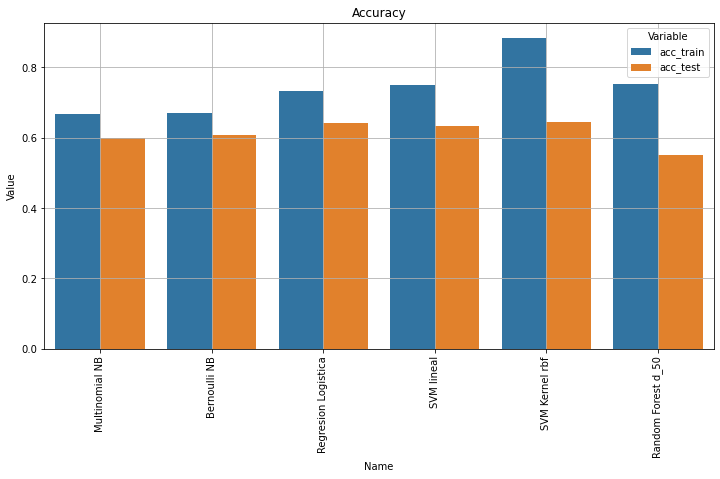

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = results[['acc_train', 'acc_test']].reset_index().melt(id_vars='name').rename(columns=str.title)

# Pintamos el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='Name', y='Value', hue='Variable', data=df_plot)
plt.title("Accuracy")
plt.grid()
plt.xticks(rotation=90)
plt.show()

<hr>


# Elección del modelo y exportación en "Pickle"


* El "mejor" modelo (a nivel de accuracy) es el creado por el algoritmo de aprendizaje del ***Support Vector Machine*** utilizando el kernel "***rbf***"; si bien es cierto que sobreajusta bastante a los datos de entrenamiento, obtiene bastantes buenos resultados con los datos de test.


* Dado que este ejercicio es una prueba de concepto no vamos a profundizar mucho en la elección del modelo y seleccionaremos el que mejor accuracy tenga.


##### NOTAS:
##### 1.- Esta elección del modelo se ha realizado con los tweets leidos en el momento de la ejecución. Es posible que si este proceso se ejecuta en otro momento con otros tweets, el mejor modelo puede ser otro.
##### 2.- Para la resolución de este problema se pueden utilizar otros algoritmos de aprendizaje o métodos ensemble que resuelvan problemas de clasificación. También este problema se puede mejorar estudiando los hiperparámetros que se le pasa a los Algoritmos de Aprendizaje.



## 1. Creacción del Modelo con todos los tweets


* Una vez que hemos seleccionado el Algoritmo de Aprendizaje (***Support Vector Machine***) que mejor modelos genera, vamos a crear un modelo utilizando todos los datos (tweets) disponibles en el dataset.


* Pasamos a crear el modelo con todos los datos:

In [12]:
from sklearn.svm import SVC

best_model = SVC(kernel='rbf')
best_model.fit(X_bow, y)

SVC()

* Obtenemos las métricas del modelo con los propios datos de entrenamiento

In [13]:
from sklearn.metrics import classification_report
labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']
print(classification_report(y_true=y, y_pred=best_model.predict(X_bow), labels=labels))

              precision    recall  f1-score   support

        psoe       0.92      0.88      0.90     10045
          pp       0.88      0.87      0.88      9768
         vox       0.81      0.93      0.87     10385
     podemos       0.89      0.87      0.88      8676
  ciudadanos       0.95      0.84      0.89      7295

    accuracy                           0.88     46169
   macro avg       0.89      0.88      0.88     46169
weighted avg       0.89      0.88      0.88     46169



* Pintamos la matriz de confusión para hacernos una idea de como clasifica el modelo seleccionado.

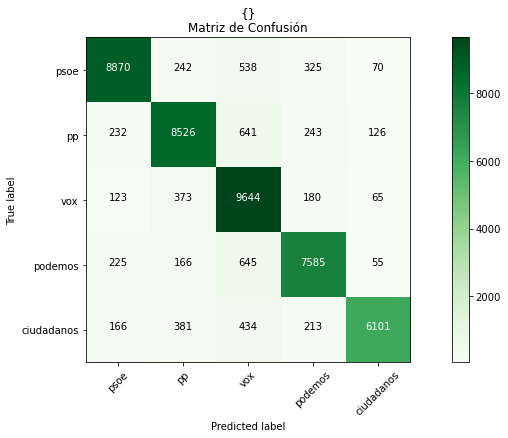

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true=y, y_pred=best_model.predict(X_bow), labels=labels)   

# Pintamos la matriz de confusión
plt.figure(figsize=(12, 6))
plot_confusion_matrix(cm, classes=labels, title='{}\nMatriz de Confusión')

## 2. Exportación del Modelo Pickle


* Ahora vamos a exportar el modelo creado por el Algoritmo de Aprendizaje en formato pickle.


* El modelo creado se ha generado con una determinada ***bolsa de palabras*** que contenia 1000 Palabras en su diccionario. Por tanto tambien tenemos que exportar el modelo generado por el ***CountVectorizer*** para que los nuevos tweets a predecir se ajusten a esa BoW.


* Por tanto tenemos que realizar:
    1. Exportar el ***Modelo*** generado por el Algoritmo de Aprendizaje.
    2. Exportar la ***Bolsa de Palabras*** generado por la clase ***CountVectorizer***.
    
    
* Exportamos el modelo generado por el Algoritmo de Aprendizaje.

In [15]:
import pickle

filename = './models/best_model_tweets_politica.pickle'
save_model = open(filename,"wb")
pickle.dump(best_model, save_model) # con la función 'dump' guardamos el modelo
save_model.close()

* Exportar la ***Bolsa de Palabras*** generado por la clase ***CountVectorizer***.

In [16]:
filename = './models/vectorizer_bow_tweets_politica.pickle'
save_bow = open(filename,"wb")
pickle.dump(vectorizer, save_bow)
save_bow.close()

<hr>


# Bonus Track - Nubes de Palabras (WordCloud)


* Un punto interesante cuando trabajamos con la clasificación de textos subjetivos (Análisis de Sentimientos) es la de ver cuales son las palabras relevantes de cada una de las clases.


* Una representación trivial sería la de crear una gráfica de barras en la que mostrasemos la relación entre la palabra y su frecuencia (el número de veces que aparece). Este tipo de representación (gráfico de barras); cuando trabajamos con textos, no suele aportarnos una información demasiado descriptiva ya que hay pocas palabras dentro de una clase que se repiten muchas veces y otras que siendo relevantes y descriptivas de la clase aparecen 'n' veces menos que la palabra más relevante, por lo tanto tendríamos una gráfica de barras muy desbalanceada.


* Una buena representación para ver la relevancia de las palabras dentro de una clase son las "Nubes de Palabras" (Word Cloud) que son una representación visual de las palabras que conforman un texto, en donde el tamaño es mayor para las palabras que aparecen con más frecuencia.


* Con esta representación podemos ver cuales son las palabras más relevantes así como otras palabras que también son relevantes pero que tienen una menor frecuencia.


* Una de las librerías en python para realizar este tipo de tareas es "WordCloud": https://amueller.github.io/word_cloud/


* Veamos a continuación un sencillo ejemplo de nubes de palabras para todos los Tweets y por partido político.

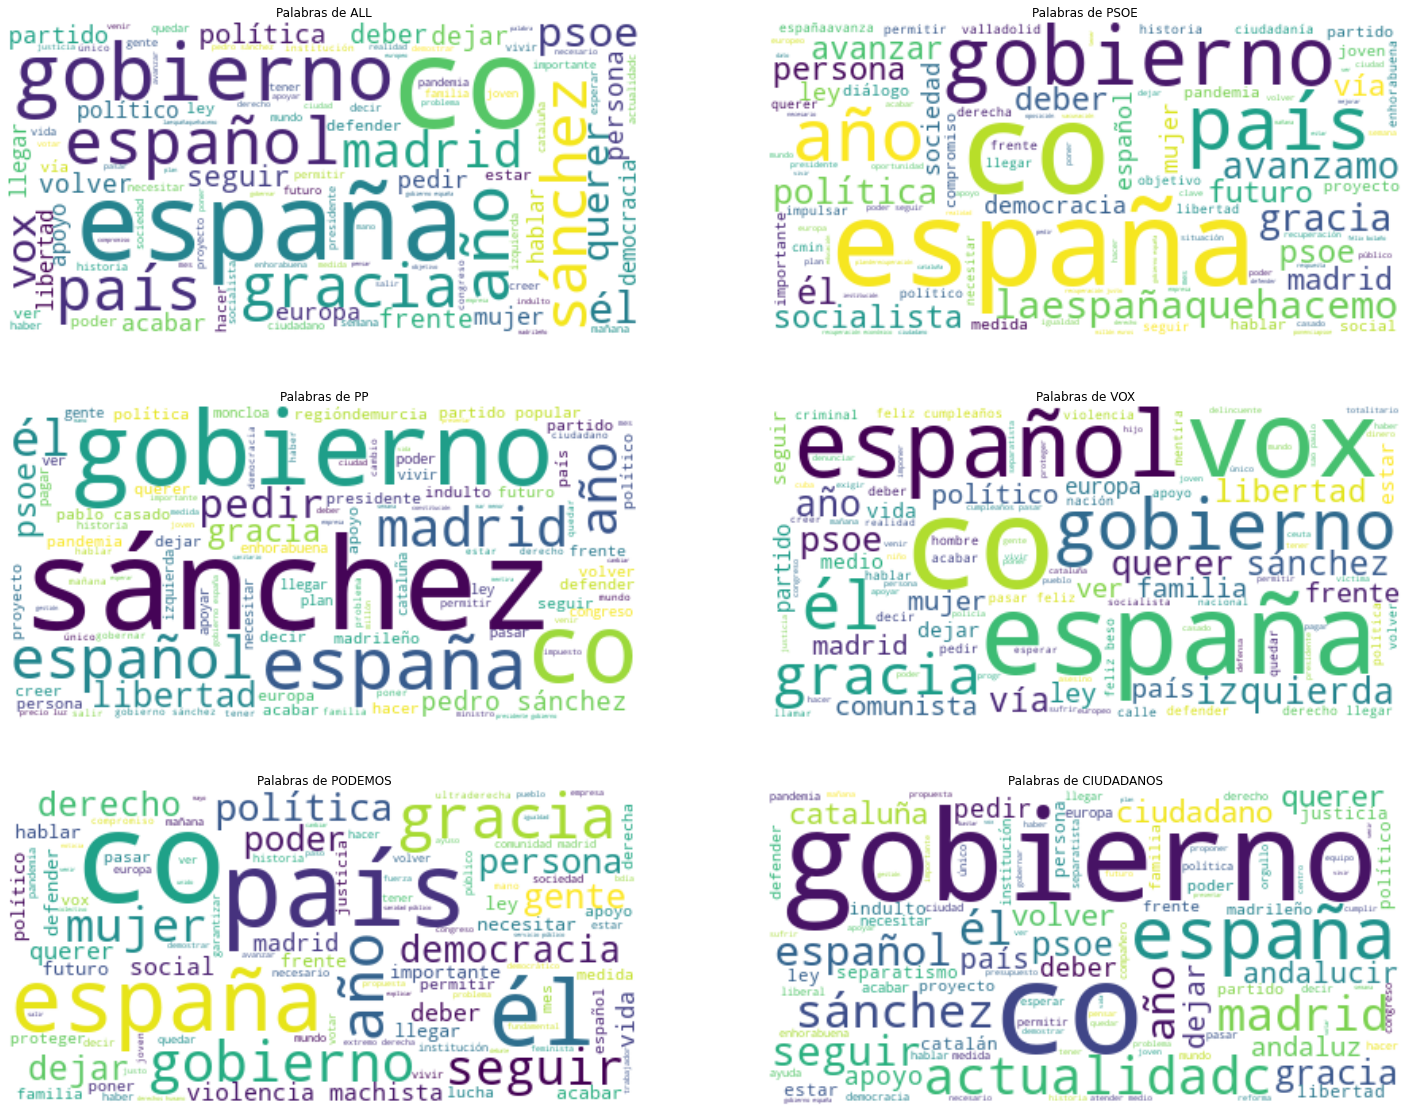

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


words_partidos = {
    'all': ' '.join([tweet[0] for tweet in X_norm]),
    'psoe': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "psoe"]),
    'pp': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "pp"]),
    'vox': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "vox"]),
    'podemos': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "podemos"]),
    'ciudadanos': ' '.join([X_norm[i][0] for i, x in enumerate(y) if x == "ciudadanos"])
}

plt.figure(figsize=(25, 20))
pos = 1
for key, words in words_partidos.items():
    plt.subplot(3, 2, pos)
    wordcloud = WordCloud(max_font_size=80, max_words=100, background_color="white").generate(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras de {}".format(key.upper()))
    pos += 1
plt.show()